In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant
import time

In [3]:
## Load necessary data
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))

Optimal


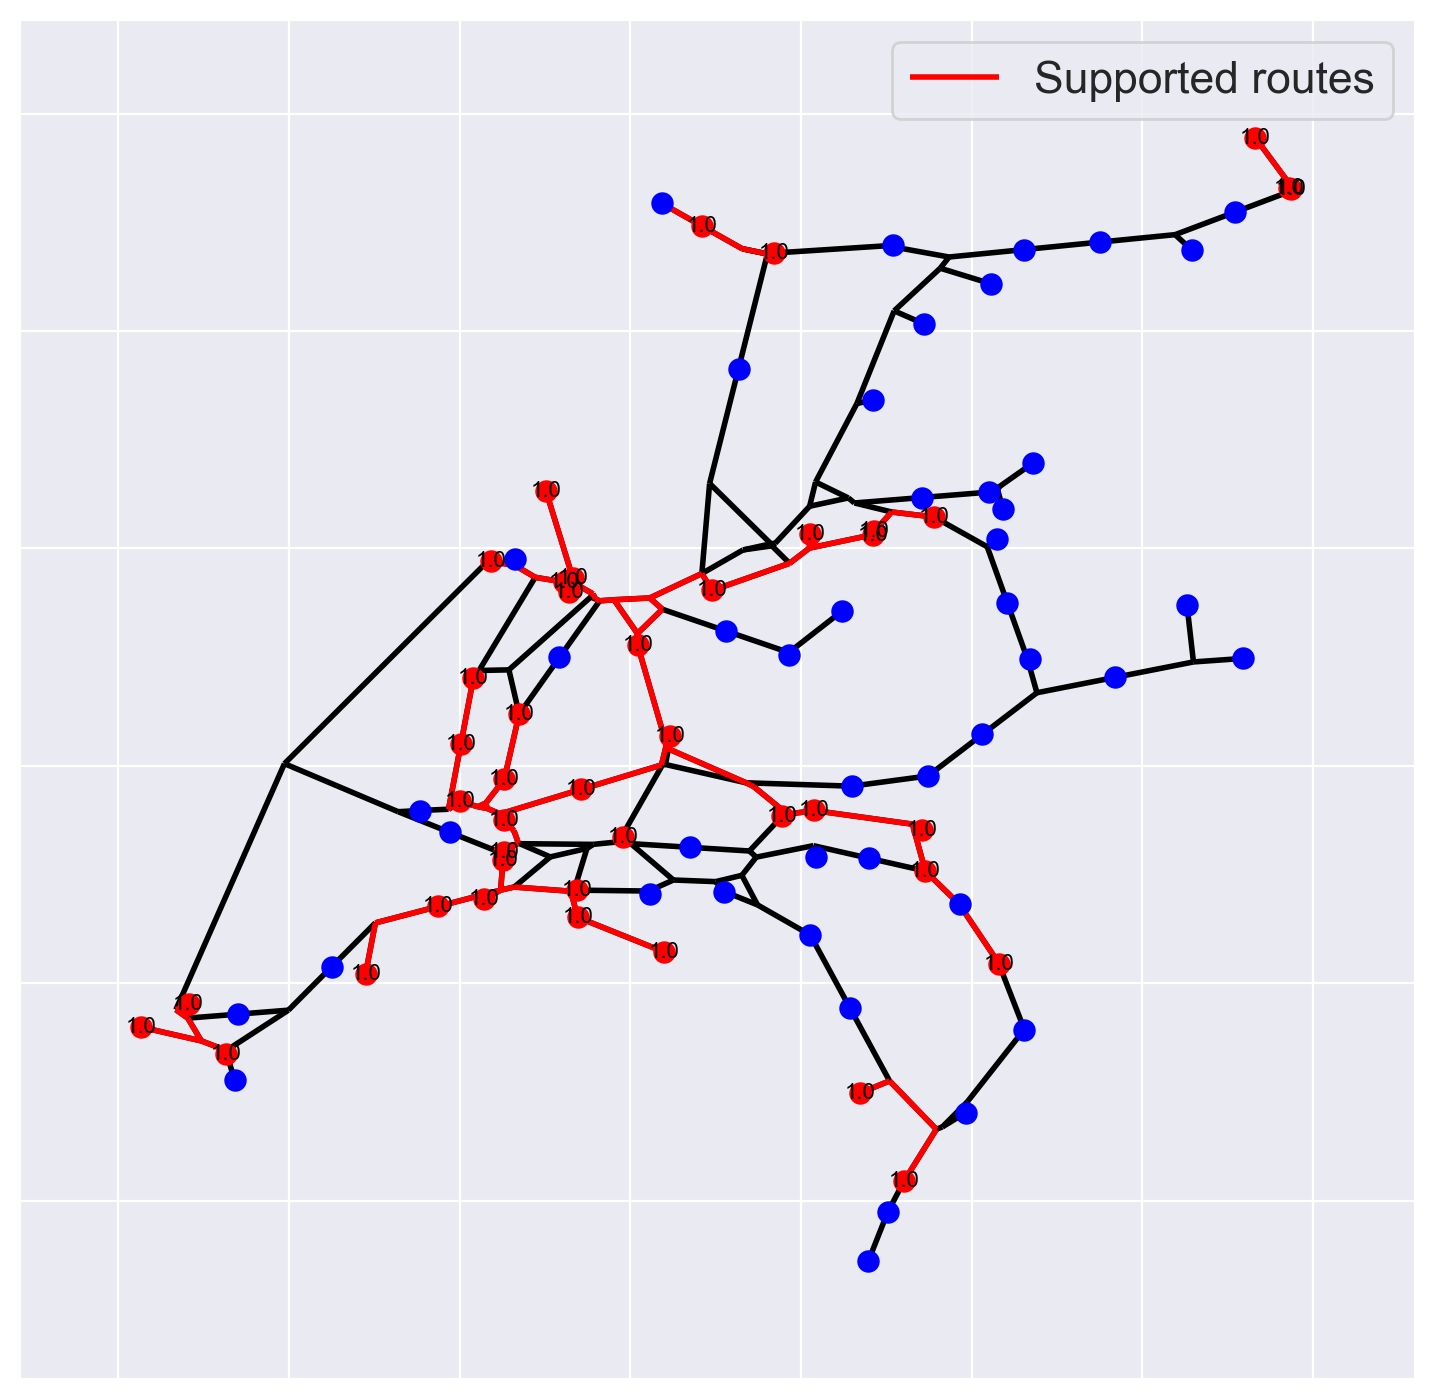

CPU times: total: 10.2 s
Wall time: 10.6 s
Optimal


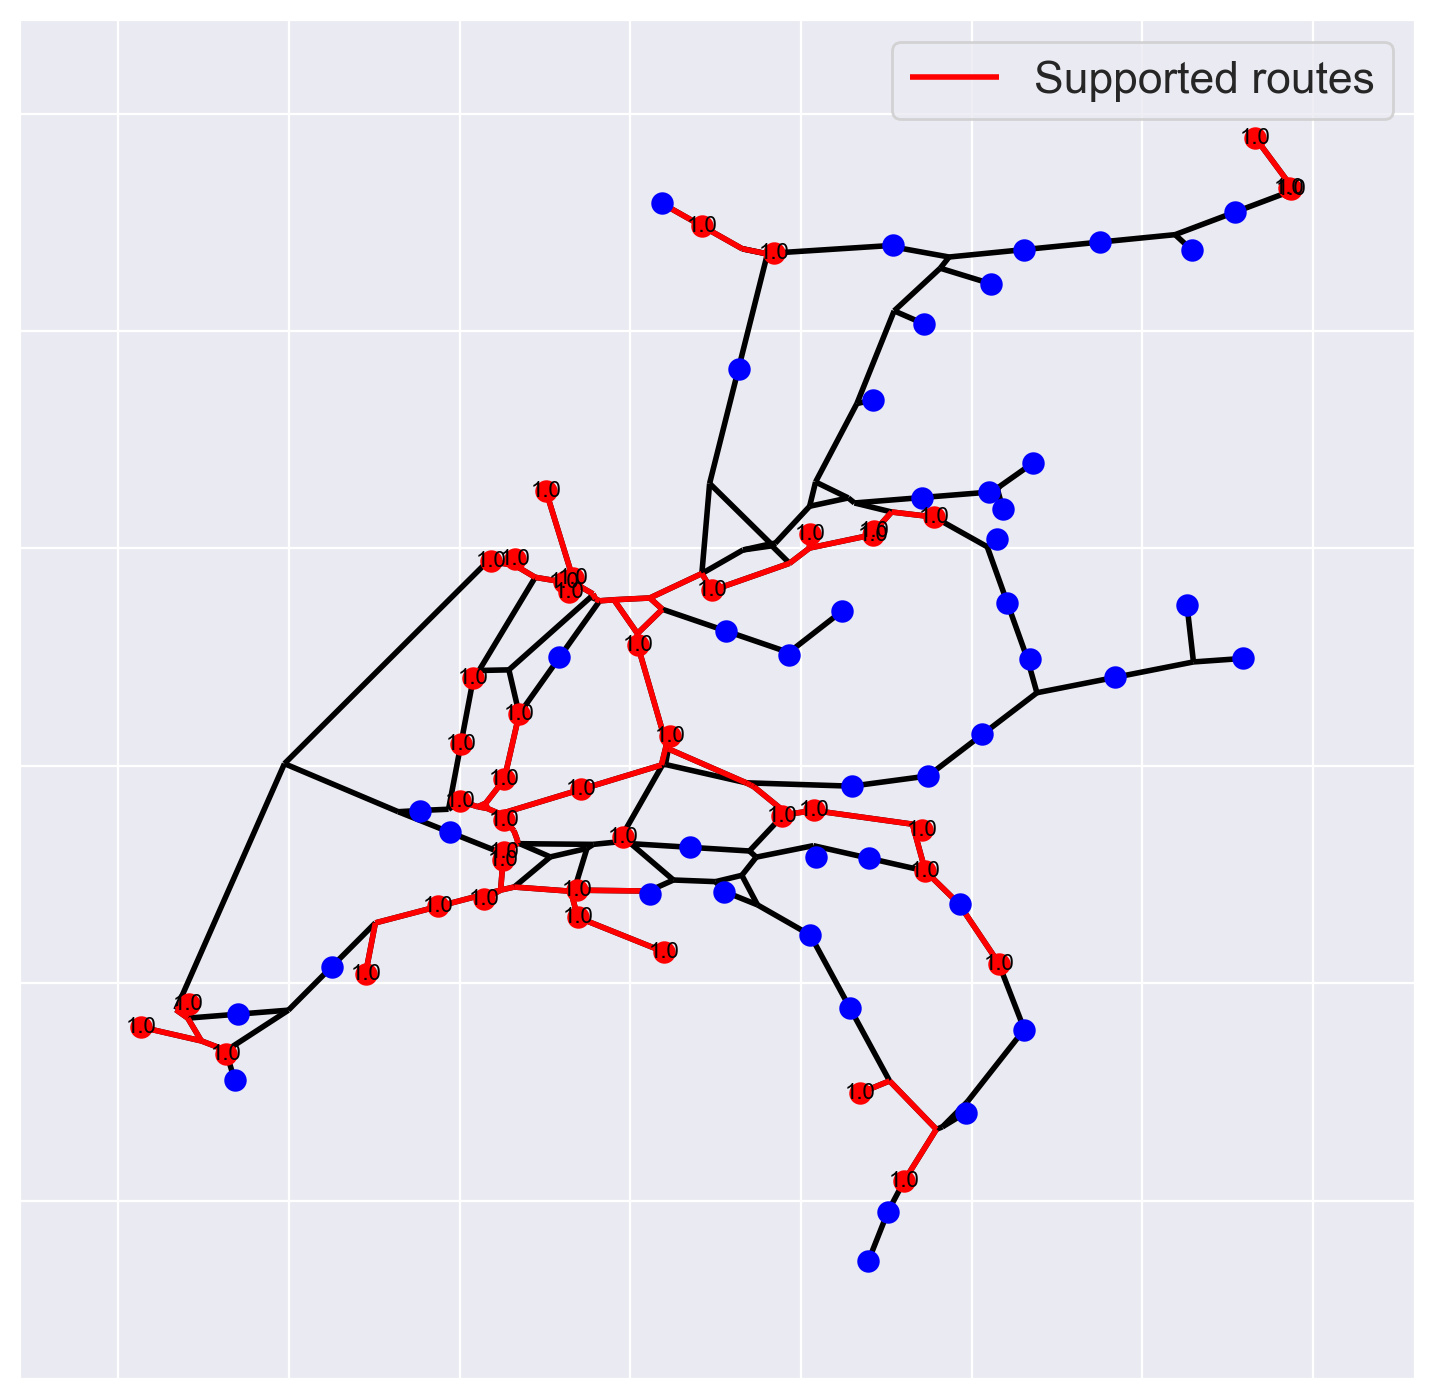

CPU times: total: 10.9 s
Wall time: 11.1 s


In [5]:
%%time
total_flow, fraction_captured_total, serveable_fraction, served_fraction, routes_supported = flow_refueling_location_model(1, 50000, 50, 1000, 1, 20, vis=True)

In [4]:
3total_flow

1259.269197651663

In [5]:
fraction_captured_total

0.24173502557523754

In [6]:
serveable_fraction

0.7003581240298169

In [7]:
served_fraction

0.345159165405706

In [8]:
routes_supported

47.0

## Works, now connect to workbench

In [3]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [4]:
#define parameters
model.constants = [
    Constant("additional_nodes", 0),
]

model.uncertainties = [
    CategoricalParameter("load", [0.75, 1, 1.25]),
    RealParameter("r", 40000, 80000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 10, 100),
    IntegerParameter("station_cap", 1000, 2500),
    CategoricalParameter("max_per_loc", [1, 2, 3]),
    # CategoricalParameter("additional_nodes", [0, 30, 60]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serveable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
]

In [5]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=30, policies=75)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 30 scenarios * 75 policies * 1 model(s) = 2250 experiments
100%|████████████████████████████████████| 2250/2250 [1:13:06<00:00,  1.95s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
pickle.dump( experiments, open( "results/experiments_new3075.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_new3075.p", "wb") )
# experiments = pickle.load( open("results/experiments_300s_10.p", "rb"))
# outcomes = pickle.load( open("results/outcomes_300s_10.p", "rb"))

## Run model for 300 and 10 policies without changing station cap and max per loc

In [7]:
experiments

load             r max_per_loc  station_cap  stations_to_place scenario  \
0     1.25  46084.548022           1       2041.0               51.0       75   
1        1  59396.144413           1       2041.0               51.0       76   
2        1  41481.555284           1       2041.0               51.0       77   
3        1  75165.705941           1       2041.0               51.0       78   
4        1  62506.903267           1       2041.0               51.0       79   
...    ...           ...         ...          ...                ...      ...   
2245  0.75  64069.772525           1       1508.0               41.0      100   
2246     1  58457.026138           1       1508.0               41.0      101   
2247  1.25  53757.171456           1       1508.0               41.0      102   
2248  1.25  71880.427823           1       1508.0               41.0      103   
2249  0.75  43002.821472           1       1508.0               41.0      104   

     policy model  
0         0  frlm  
1         0  frlm  
2         0  frlm  
3         0  frlm  
4         0  frlm  
...     ...   ...  
2245     74  frlm  
2246     74  frlm  
2247     74  frlm  
2248     74  frlm  
2249     74  frlm  

[2250 rows x 8 columns]

## Visualize results for each policy in a pairplot

In [8]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

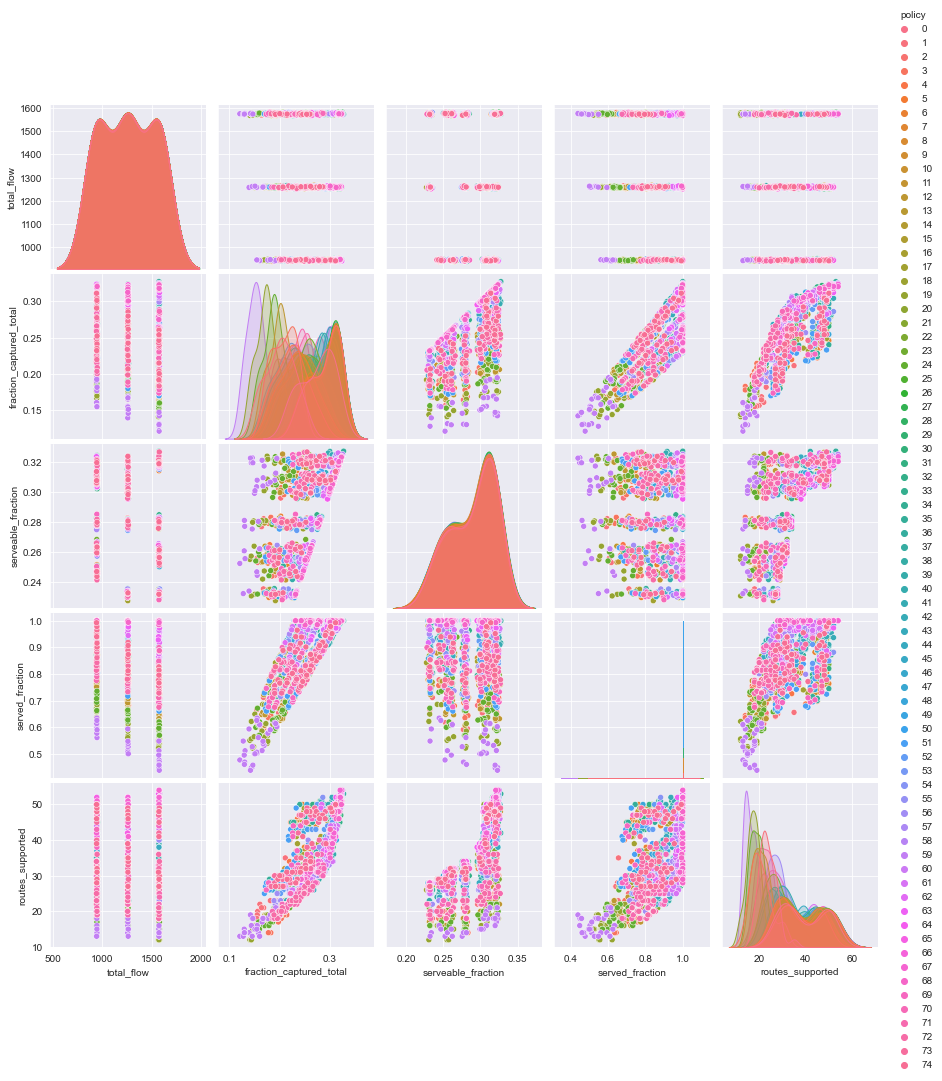

In [9]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

## "Normal" pairplot?

In [11]:
all_data = experiments.copy()
all_data['total_flow'] = outcomes['total_flow']
all_data['fraction_captured_total'] = outcomes['fraction_captured_total']
all_data['serveable_fraction'] = outcomes['serveable_fraction']
all_data['served_fraction'] = outcomes['served_fraction']
all_data['routes_supported'] = outcomes['routes_supported']

In [12]:
all_data

load             r max_per_loc  station_cap  stations_to_place scenario  \
0     1.25  46084.548022           1       2041.0               51.0       75   
1        1  59396.144413           1       2041.0               51.0       76   
2        1  41481.555284           1       2041.0               51.0       77   
3        1  75165.705941           1       2041.0               51.0       78   
4        1  62506.903267           1       2041.0               51.0       79   
...    ...           ...         ...          ...                ...      ...   
2245  0.75  64069.772525           1       1508.0               41.0      100   
2246     1  58457.026138           1       1508.0               41.0      101   
2247  1.25  53757.171456           1       1508.0               41.0      102   
2248  1.25  71880.427823           1       1508.0               41.0      103   
2249  0.75  43002.821472           1       1508.0               41.0      104   

     policy model   total_flow  fraction_captured_total  serveable_fraction  \
0         0  frlm  1574.530020                 0.219668            0.253261   
1         0  frlm  1261.160000                 0.291438            0.300584   
2         0  frlm  1256.722740                 0.234561            0.234561   
3         0  frlm  1260.953112                 0.308877            0.323540   
4         0  frlm  1261.548728                 0.294411            0.306477   
...     ...   ...          ...                      ...                 ...   
2245     74  frlm   943.005636                 0.290775            0.307730   
2246     74  frlm  1260.638669                 0.242338            0.298419   
2247     74  frlm  1573.810411                 0.214902            0.280321   
2248     74  frlm  1572.976204                 0.253949            0.319032   
2249     74  frlm   943.917025                 0.232098            0.246942   

      served_fraction  routes_supported  
0            0.867360              29.0  
1            0.969574              37.0  
2            1.000000              28.0  
3            0.954680              51.0  
4            0.960629              41.0  
...               ...               ...  
2245         0.944905              46.0  
2246         0.812072              35.0  
2247         0.766628              29.0  
2248         0.795997              48.0  
2249         0.939889              28.0  

[2250 rows x 13 columns]

In [13]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

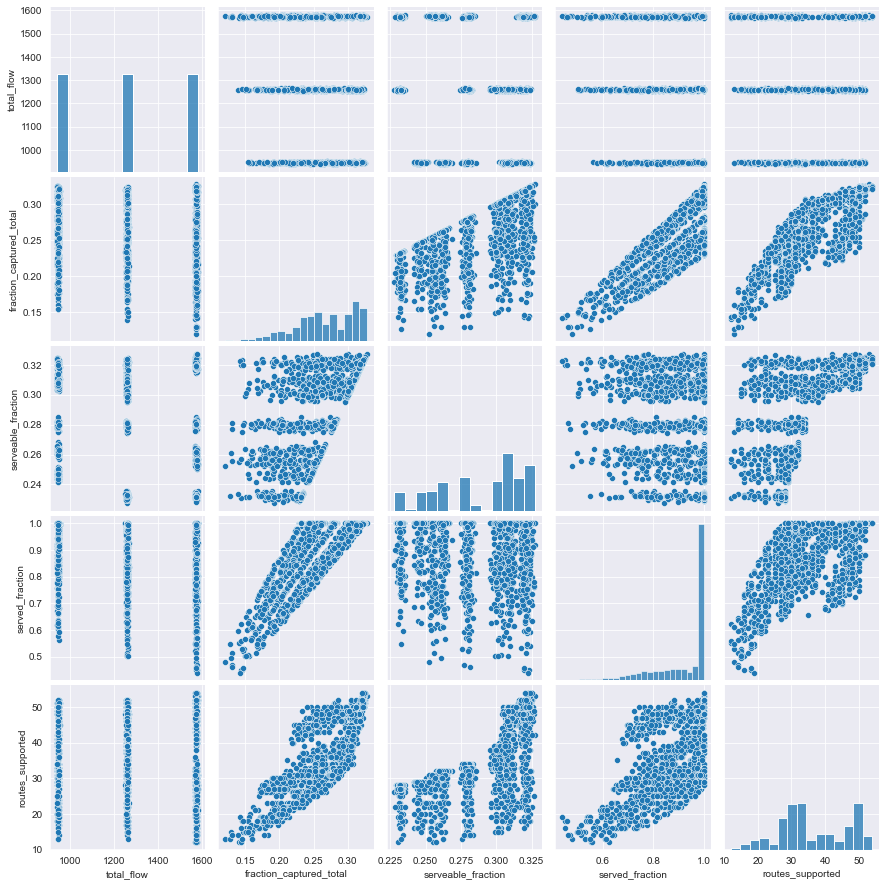

In [14]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

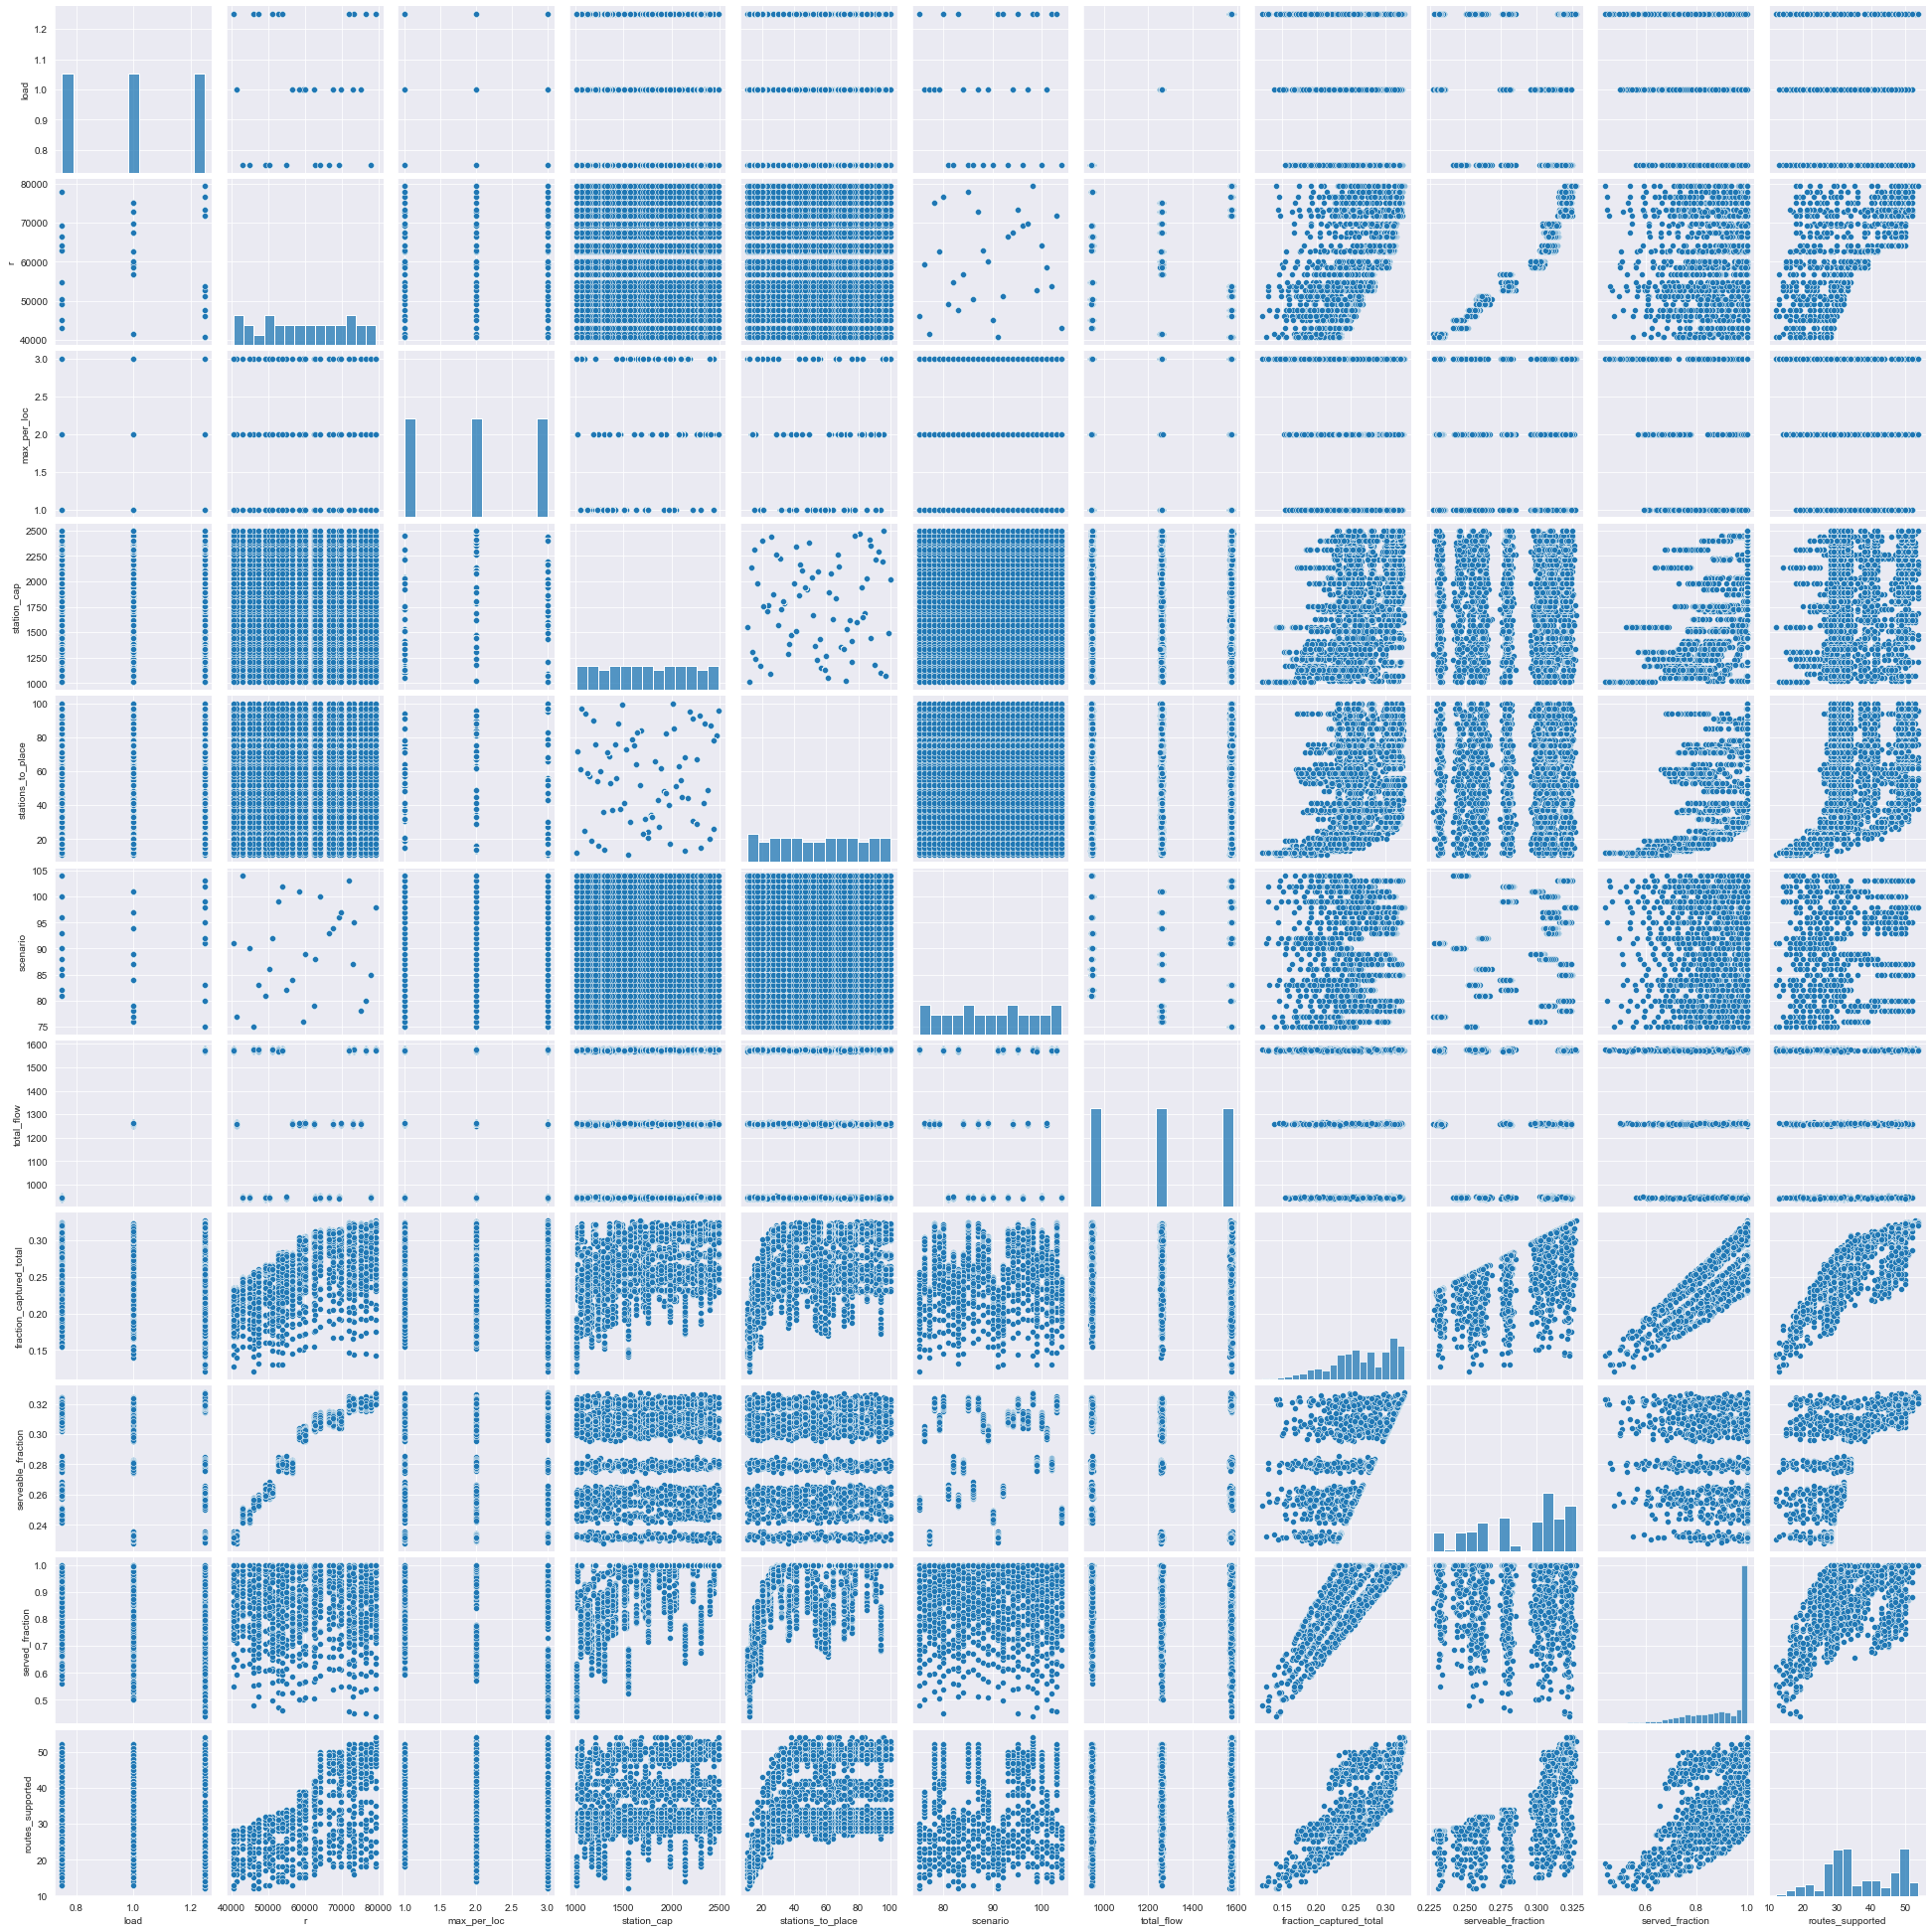

In [15]:
sns.pairplot(all_data)

In [10]:
all_data

load         r  additional_nodes  stations_to_place scenario policy  \
0   1.033713  154484.0              21.0              215.0        4      0   
1   0.913505   59401.0              21.0              215.0        5      0   
2   1.196304  176424.0              21.0              215.0        6      0   
3   0.806994  104827.0              21.0              215.0        7      0   
4   1.033713  154484.0               0.0              133.0        4      1   
5   0.913505   59401.0               0.0              133.0        5      1   
6   1.196304  176424.0               0.0              133.0        6      1   
7   0.806994  104827.0               0.0              133.0        7      1   
8   1.033713  154484.0              26.0              232.0        4      2   
9   0.913505   59401.0              26.0              232.0        5      2   
10  1.196304  176424.0              26.0              232.0        6      2   
11  0.806994  104827.0              26.0              232.0        7      2   
12  1.033713  154484.0              39.0               32.0        4      3   
13  0.913505   59401.0              39.0               32.0        5      3   
14  1.196304  176424.0              39.0               32.0        6      3   
15  0.806994  104827.0              39.0               32.0        7      3   

   model   total_flow  supported_fraction  routes_supported  extra_nodes_used  
0   frlm  1299.221370            0.403833              66.0              10.0  
1   frlm  1152.131742            0.209634              32.0               3.0  
2   frlm  1506.011585            0.406135              66.0              11.0  
3   frlm  1016.916164            0.341347              58.0               5.0  
4   frlm  1304.643992            0.355655              76.0               0.0  
5   frlm  1147.843366            0.200858              32.0               0.0  
6   frlm  1509.172994            0.357467              73.0               0.0  
7   frlm  1015.461996            0.309784              57.0               0.0  
8   frlm  1301.642114            0.402719              67.0              12.0  
9   frlm  1146.572994            0.210707              36.0               7.0  
10  frlm  1507.451507            0.409704              78.0              14.0  
11  frlm  1018.600157            0.349064              65.0              10.0  
12  frlm  1303.040548            0.171263              26.0               0.0  
13  frlm  1150.614403            0.091938              17.0               2.0  
14  frlm  1506.115616            0.163269              26.0               0.0  
15  frlm  1016.028102            0.170151              22.0               0.0

In [ ]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

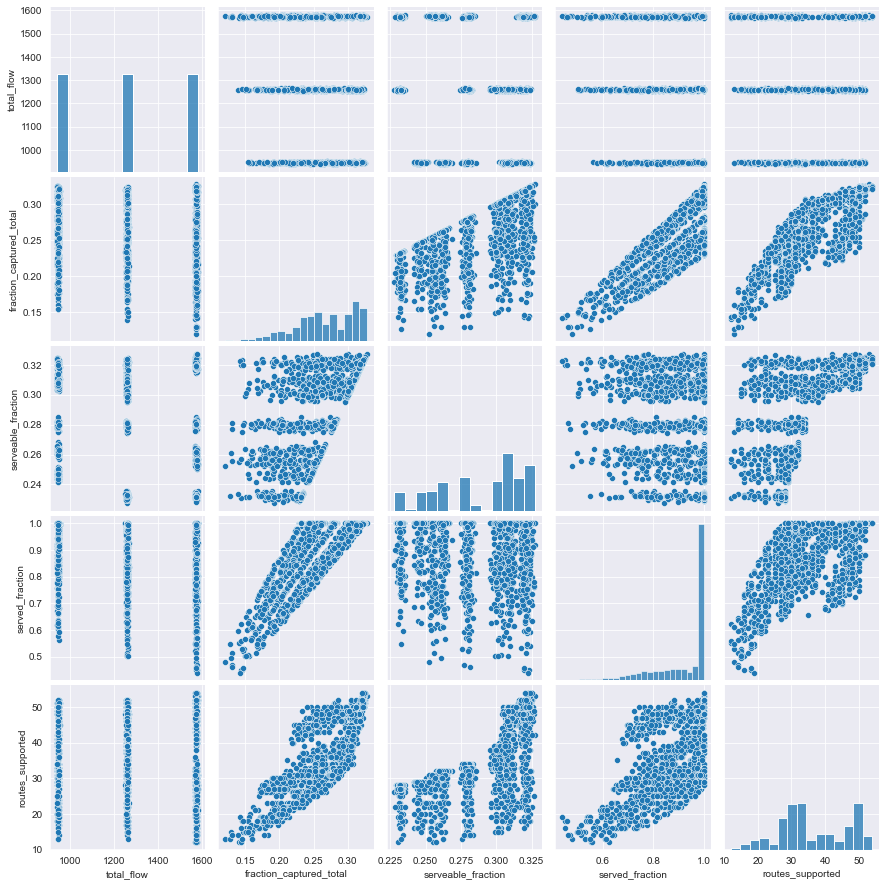

In [16]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

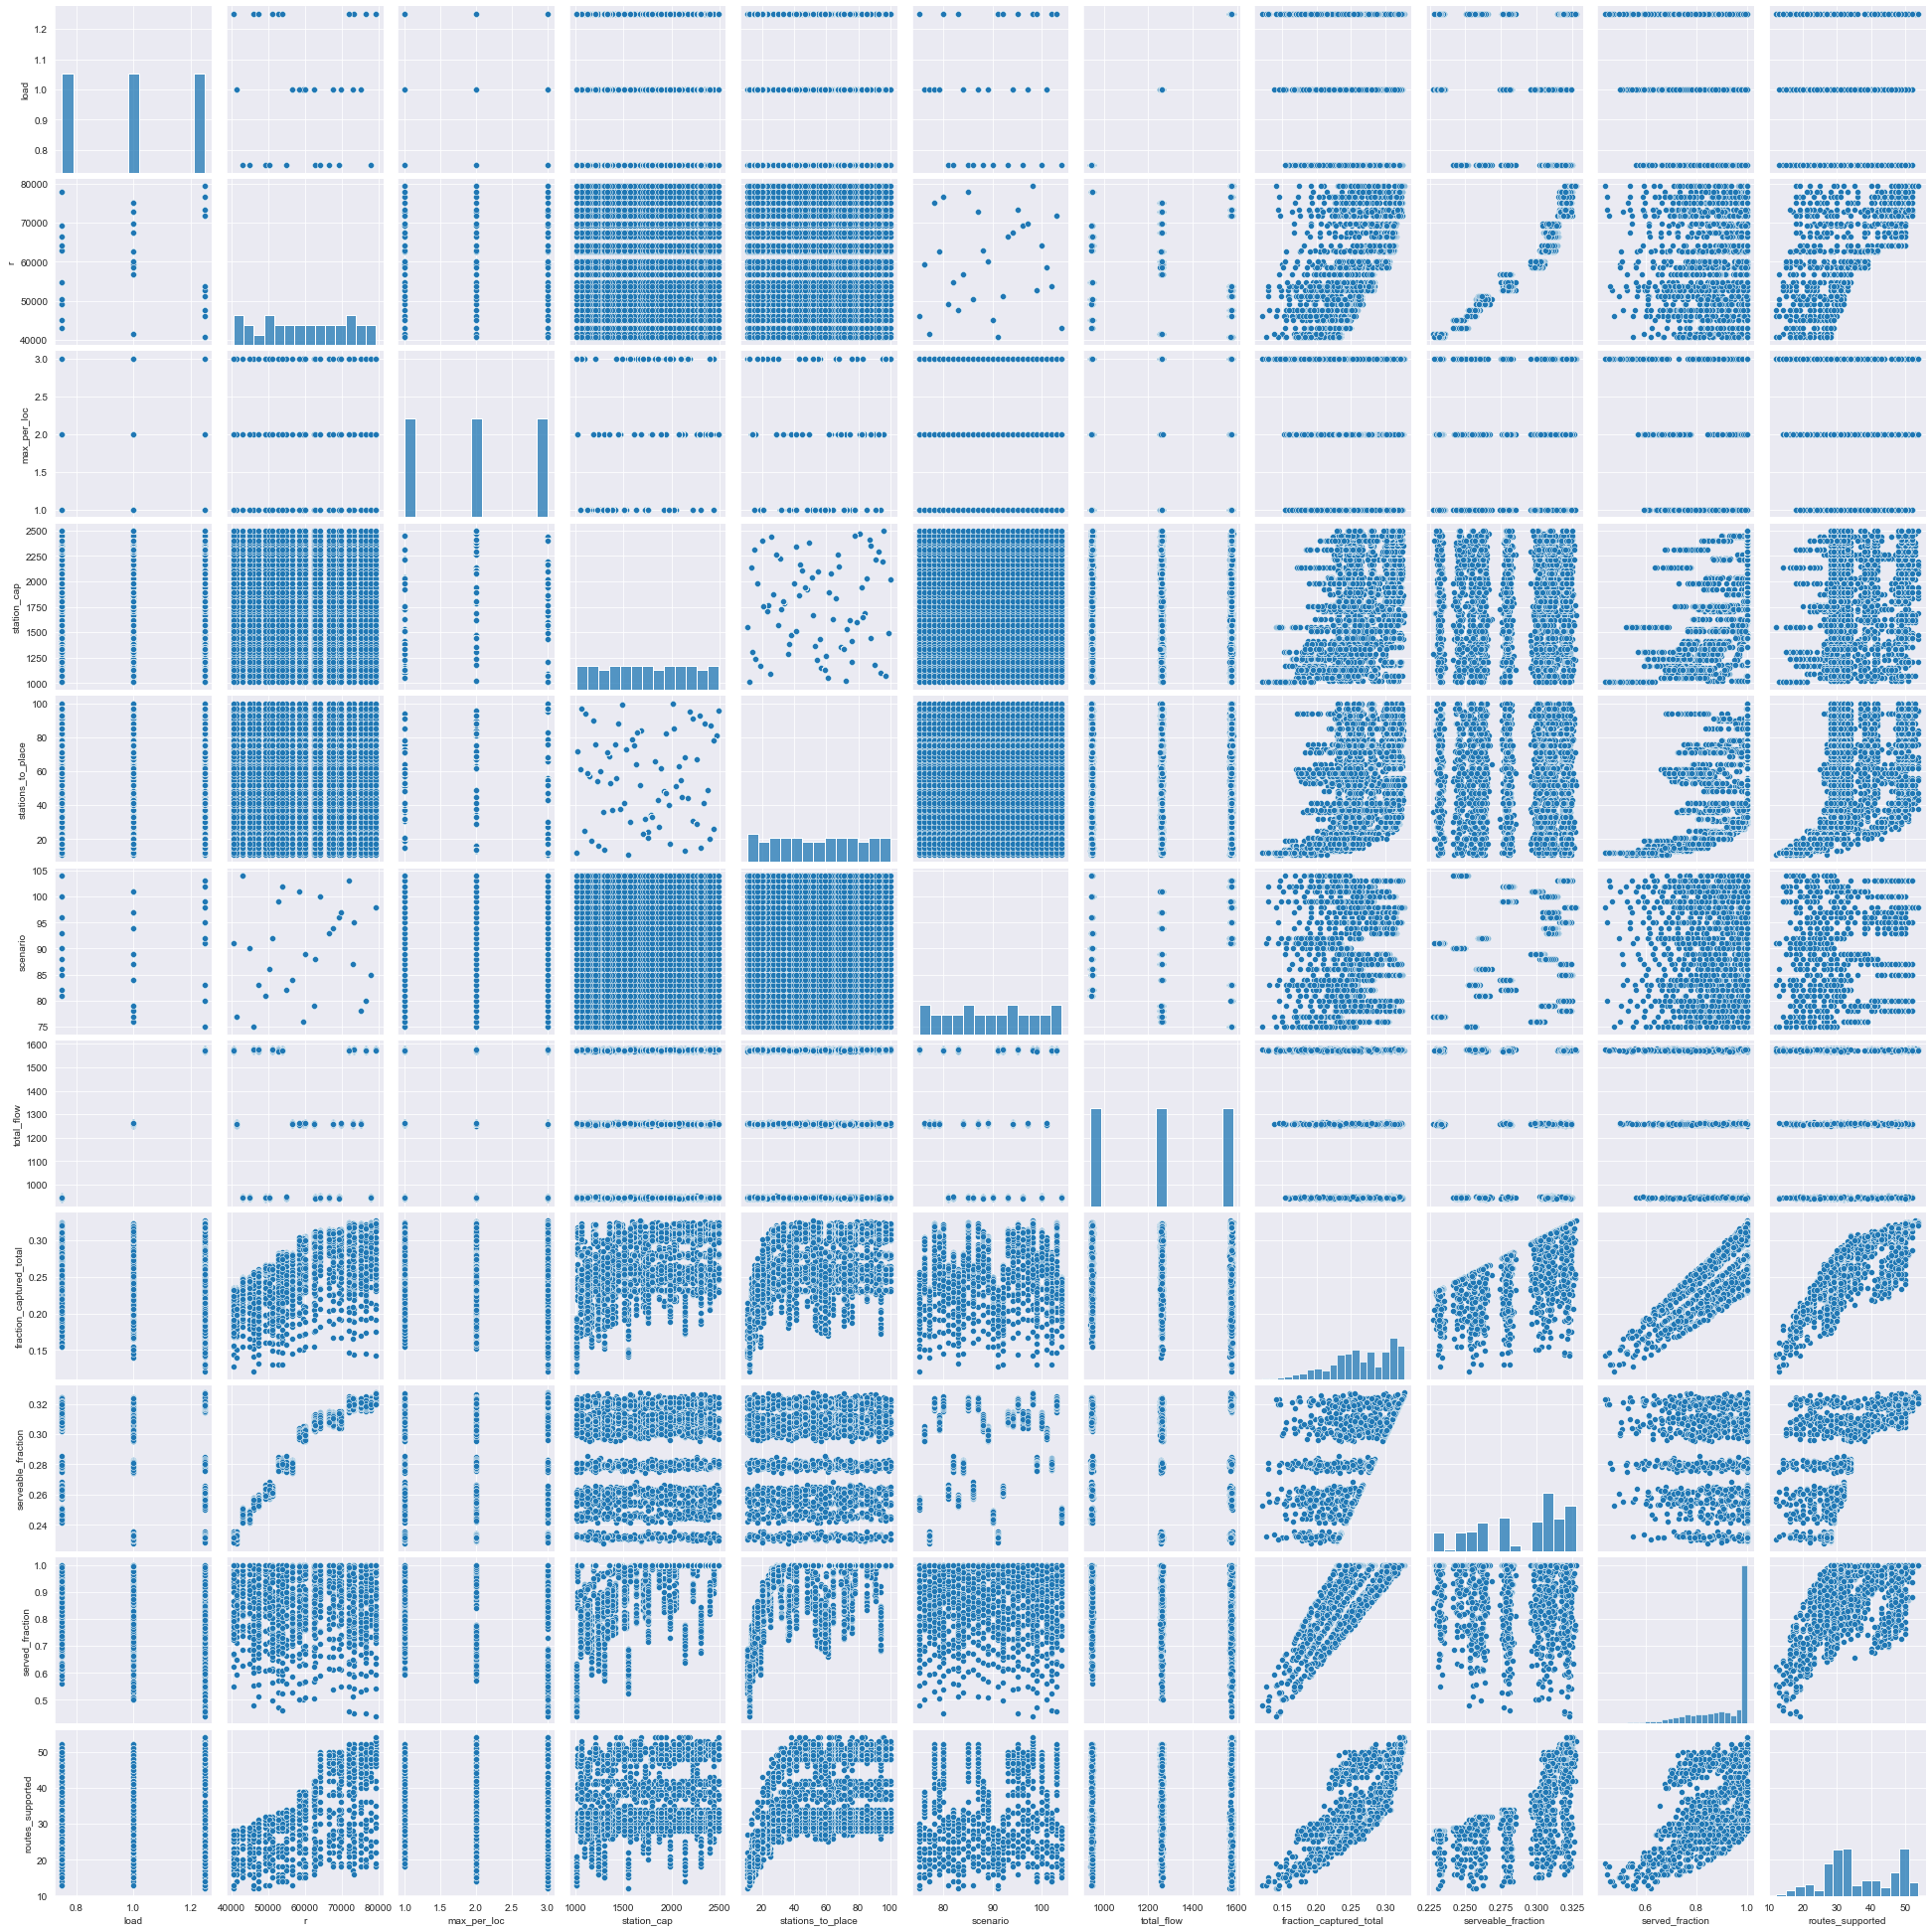

In [17]:
sns.pairplot(all_data)

## Visualize how results are correlated

[MainProcess/INFO] no time dimension found in results


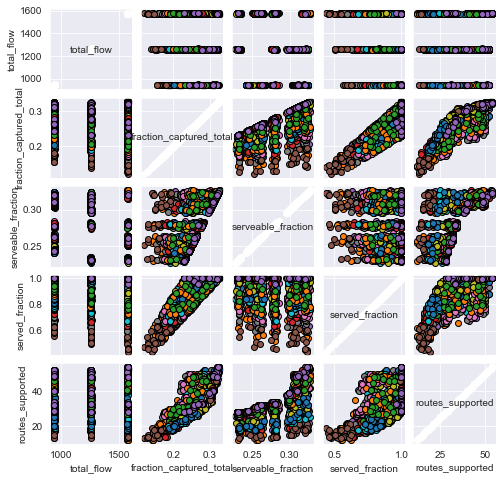

In [18]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(8, 8)
plt.show()

In [19]:
from ema_workbench.analysis import prim
%matplotlib inline
x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

KeyError: 'supported_fraction'

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect(10)
box1.inspect(10, style="graph")
plt.show()

In [ ]:
box1.show_pairs_scatter(10)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\ema_workbench\analysis\feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anac

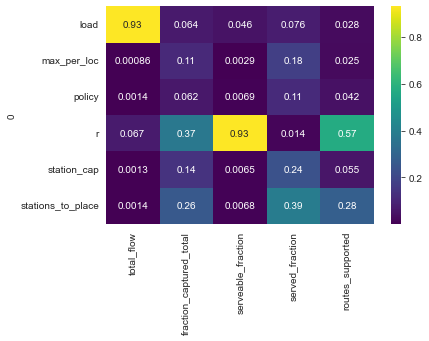

In [20]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [ ]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (1-outcomes["supported_fraction"]) < 0.8
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (outcomes["total_flow"]) < 1000
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

## Sobol sampling

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from SALib.analyze import sobol
from ema_workbench import Samplers, Model
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome

model = Model("frlm", function=flow_refueling_location_model)
#

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
pickle.dump( sa_results, open( "results/sa_1000.p", "wb" ) )

In [ ]:

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_fraction"], calc_second_order=True, print_to_console=False
)